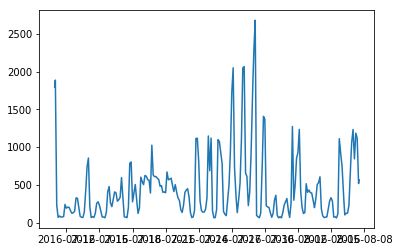

In [204]:
import os
import scipy.stats as stats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import datetime as dt
import pytz
from sklearn.utils import resample
%matplotlib inline
from matplotlib.ticker import NullFormatter

from sklearn import metrics
import Data_Processor as DP
import importlib
importlib.reload(DP)

Root = 'C:/Illisarvik/'

Flux_Path = Root+'Flux_Results/eddypro_Illisarvik_full_output_2017-03-08T142621.csv'
BL_Path = Root+'SlowMet/BL_Data.csv'
Met_Path = Root+'SlowMet/CR1000_Table1.DAT'
Soil_Path = Root+'SoilSensors/SoilData.txt'

Comp = DP.Compile(Flux_Path,BL_Path,Met_Path,Soil_Path)


Comp.Rain_Check([0,0])

Comp.Wind_Bins(30)
    
Comp.QC_Check(2)
Comp.Spike_Removal(z_thresh=4)
Comp.StorageCorrection()
Comp.Wind_Filter(30)
# Comp.ustar_Bins(15,{'Var':'PPFD_Avg','Thresh':10},{'Var':'ch4_flux','Plot':True},
#                 {'Repetitions':100,'n_samples':10000})
Comp.Ustar_Drop()

Data = Comp.Data.copy()
Data['Temp'] = (Data['Temp1']+Data['Temp2'])/2
Data['VWC'] = (Data['VWC1']+Data['VWC2'])/2
Data.to_csv(Root+'FilteredData' +str(dt.datetime.now()).split(' ')[0]+'.csv')

plt.plot(Data['PBLH'])

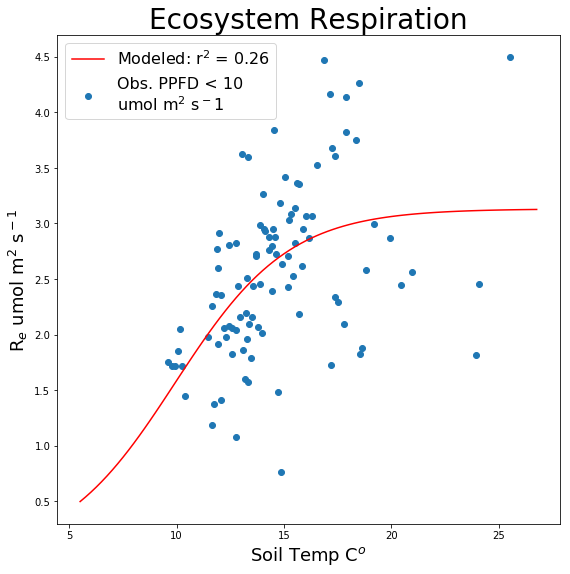

In [120]:
# import sys
# # sys.path.append('C:/Users/wesle/Dropbox/Hacks')
# # import PltHacks as PH
# import numpy as np
# import pandas as pd
# from matplotlib import pyplot as plt
# # import datetime as dt
# from scipy.optimize import curve_fit
# from scipy import stats
# from sklearn import metrics


def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def P_func(PPFD,MQY,PM):
    cv =.7
    return(MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5/(2*cv))
def Line(X,m,b):
    return(m*X+b)





Dark_Thresh = 10
Dark = Data[(Data['PPFD_Avg']<=Dark_Thresh)&(Data['fco2']>=0)]
Dark = Dark[['fco2','PPFD_Avg','Temp','u*','VWC']].dropna()
# plt.plot(Dark['fco2'])

# print(Dark['fco2'].count())

popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 4.59262144,0.5875255,0.27508822))
Data['R'] = Data['fco2']
Data.loc[Data['PPFD_Avg']>10,['R']]=np.nan
Data['R'] = Data['R'].fillna(R_func(Data['Temp'],*popt_r))
Data['GPP'] = (Data['R']-Data['fco2'])
P = Data[Data['PPFD_Avg']>=Dark_Thresh]
P = P[['GPP','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], P['GPP'],p0=(.003,12))
Data['GPP'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
Data['GPP_fill'] = P_func(Data['PPFD_Avg'],*popt_p)
## Ordered Data for Plotting fits
Temp = np.arange(Data['Temp'].min(),Data['Temp'].max(),.25)
PAR = np.arange(Data['PPFD_Avg'].min(),Data['PPFD_Avg'].max(),1)

## Calculate r2
Rsq_Resp = metrics.explained_variance_score(Dark['fco2'].values,R_func(Dark['Temp'],*popt_r))
Rsq_GPP = metrics.explained_variance_score(P['GPP'].values,P_func(P['PPFD_Avg'],*popt_p))

fig,axes = plt.subplots(nrows = 1,ncols = 1,figsize = (9,9))
axes.scatter(Dark['Temp'],Dark['fco2'],label = 'Obs. PPFD < '+str(Dark_Thresh)+'\numol m$^2$ s$^-1$')
axes.plot(Temp,R_func(Temp,*popt_r),color = 'red',label = 'Modeled: r$^2$ = '+str(np.round(Rsq_Resp,2)))
axes.legend(loc = 2,fontsize = 16)
axes.set_ylabel('R$_e$ umol m$^2$ s$^-$$^1$',fontsize = 18)
axes.set_xlabel('Soil Temp C$^o$',fontsize = 18)
axes.set_title('Ecosystem Respiration',fontsize = 28)
plt.show()



# We'll Incoroporate the chamber data here!!!

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: PerformanceWarning: indexing past lexsort depth may impact performance.


Peat Plateau Mean Diff:  1.726783216783218
Low Willow Mean Diff:  1.65927972027972
Dense Willow Mean Diff:  0.3464965034965033
Cotton Grass Mean Diff:  2.0648251748251747
Wet Sedge 1 Mean Diff:  3.3385034965034968
Tall Willow Mean Diff:  0.6801398601398603
Wet Sedge 2 Mean Diff:  2.570566433566433
Grass Mean Diff:  0.9904825174825178
Tundra Mean Diff:  4.713146853146854


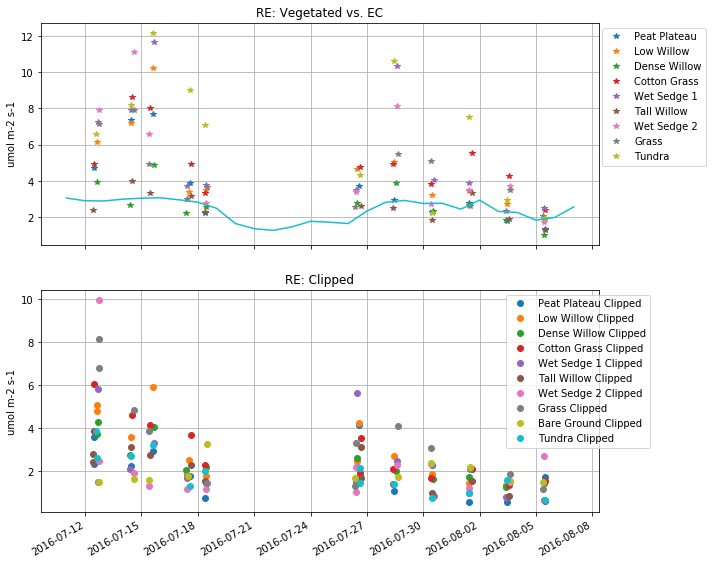

In [174]:
Names={'T12' : 'Tundra',
'B6' : 'Peat Plateau',
'C3' : 'Low Willow',
'E2' : 'Dense Willow',
'E7' : 'Cotton Grass',
'F3' : 'Wet Sedge 1',
'F8' : 'Tall Willow',
'H6' : 'Wet Sedge 2',
'H7' : 'Grass',
'J6' : 'Bare Ground'}

fig,axes = plt.subplots(2,1,figsize = (10,10),sharex=True)
for site in CD.index.get_level_values(0).unique():
    if site == 'F3' or site == 'H6':
        ax = axes[0]
    else:ax = axes[1]
    if site != 'J6':
        axes[0].plot(CD.loc[site,'veg']['CO2 Flux (umol/m2/s)'],
                 label=Names[site],marker = '*',linewidth=0)
        
#         axes[2].plot(CD.loc[site,'veg']['CO2 Flux (umol/m2/s)']-CD.loc[site,'unveg']['CO2 Flux (umol/m2/s)'],
#              linestyle=':',label=Names[site]+' Clipped',marker = 'o',linewidth=0)
        print(Names[site]+' Mean Diff: ',
  CD.loc[site,'veg']['CO2 Flux (umol/m2/s)'].mean()-CD.loc[site,'unveg']['CO2 Flux (umol/m2/s)'].mean())
    
    axes[1].plot(CD.loc[site,'unveg']['CO2 Flux (umol/m2/s)'],
             linestyle=':',label=Names[site]+' Clipped',marker = 'o',linewidth=0)
    
    
axes[0].legend(bbox_to_anchor=(1.2, 1))
axes[1].legend(bbox_to_anchor=(1.1, 1))
axes[0].plot(Data['R'].resample('D').mean())

for ax in axes:
    ax.grid()
    ax.set_ylabel('umol m-2 s-1')
axes[0].set_title('RE: Vegetated vs. EC')
axes[1].set_title('RE: Clipped')
# axes[2].set_title('R')
fig.autofmt_xdate()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: PerformanceWarning: indexing past lexsort depth may impact performance.


Peat Plateau Mean Diff:  11 13
Low Willow Mean Diff:  11 13
Dense Willow Mean Diff:  11 13
Cotton Grass Mean Diff:  11 13
Wet Sedge 1 Mean Diff:  11 13
Tall Willow Mean Diff:  11 13
Wet Sedge 2 Mean Diff:  11 13
Grass Mean Diff:  11 13
Tundra Mean Diff:  11 13
['Peat Plateau', 'Low Willow', 'Dense Willow', 'Cotton Grass', 'Wet Sedge 1', 'Tall Willow', 'Wet Sedge 2', 'Grass', 'Bare Ground', 'Tundra']


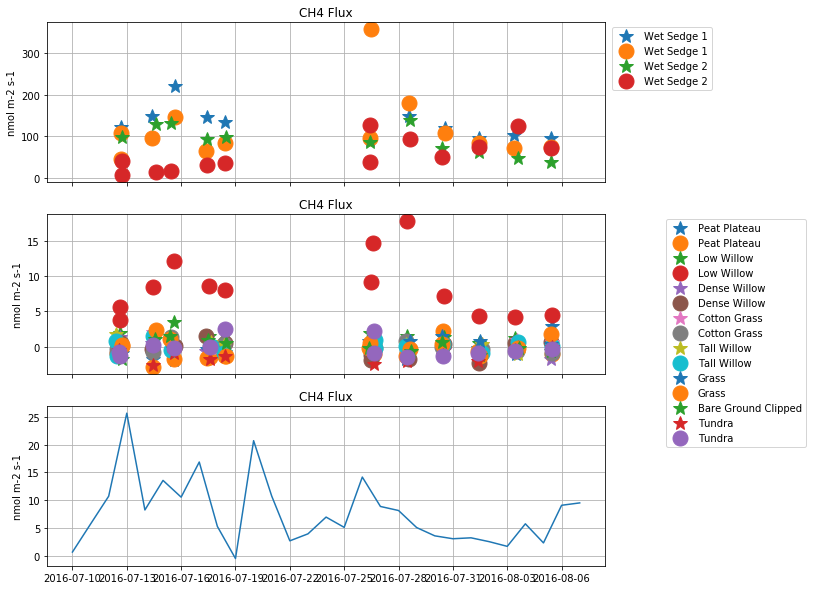

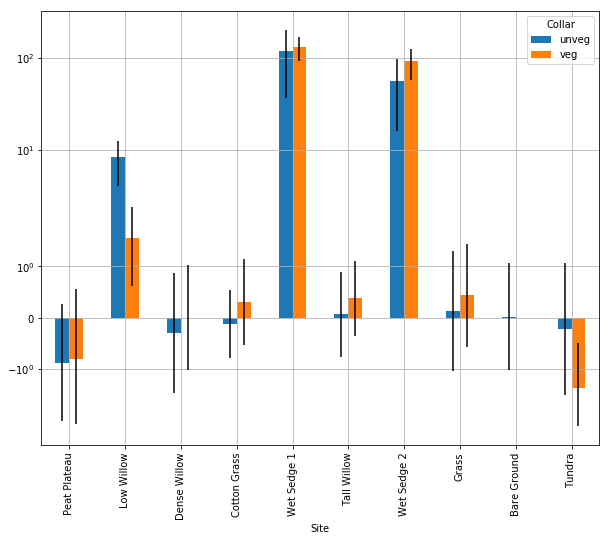

In [236]:
Names={'T12' : 'Tundra',
'B6' : 'Peat Plateau',
'C3' : 'Low Willow',
'E2' : 'Dense Willow',
'E7' : 'Cotton Grass',
'F3' : 'Wet Sedge 1',
'F8' : 'Tall Willow',
'H6' : 'Wet Sedge 2',
'H7' : 'Grass',
'J6' : 'Bare Ground'}

CD=pd.read_csv(Root+'ChamberData.csv',header=0,parse_dates={'datetime':[1,2]},
               index_col=['Site','Collar','datetime'])

# print(CD)

fig,axes = plt.subplots(3,1,figsize = (10,10),sharex=True)
for site in CD.index.get_level_values(0).unique():
    if site == 'F3' or site == 'H6':
        ax = axes[0]
    else:ax = axes[1]
    if site != 'J6':
        ax.plot(CD.loc[site,'veg']['CH4 Flux  (nmol/m2/s)'],
                 label=Names[site],marker = '*',linewidth=0,markersize=15)
        ax.plot(CD.loc[site,'unveg']['CH4 Flux  (nmol/m2/s)'],
                 label=Names[site],marker = 'o',linewidth=0,markersize=15)
        
        print(Names[site]+' Mean Diff: ',
  CD.loc[site,'veg']['CH4 Flux  (nmol/m2/s)'].count(),
              CD.loc[site,'unveg']['CH4 Flux  (nmol/m2/s)'].count())
    else:
        ax.plot(CD.loc[site,'unveg']['CH4 Flux  (nmol/m2/s)'],
             linestyle=':',label=Names[site]+' Clipped',marker = '*',linewidth=0,markersize=15)
    
axes[0].legend(bbox_to_anchor=(1.2, 1))
axes[1].legend(bbox_to_anchor=(1.1, 1))
axes[2].plot(Data['fch4'].resample('D').mean()*1000)


for ax in axes:
    ax.grid()
    ax.set_ylabel('nmol m-2 s-1')
    ax.set_title('CH4 Flux')

    
# CD2 = CD.resample('D').mean()

level_values = CD.index.get_level_values
CDMean = CD.groupby([level_values(i) for i in [0,1]]).mean()
CDStd = CD.groupby([level_values(i) for i in [0,1]]).std()
#                       +[pd.Grouper(freq='2D', level=-1)]).mean())
# print(CD2)

fig,ax = plt.subplots(1,1,figsize= (10,8))
CD2['CH4 Flux  (nmol/m2/s)'].unstack().plot.bar(stacked=False,yerr=CDStd['CH4 Flux  (nmol/m2/s)'].unstack(),ax=ax)
# CD2['CH4 Flux  (nmol/m2/s)'].unstack().plot(kind='errorbar', stacked=False)
plt.yscale('symlog')
plt.grid()
XL = [item.get_text() for item in ax.get_xticklabels()]
for i,l in enumerate(XL):
    XL[i] = Names[l]

ax.set_xticklabels(XL)
print(XL)

# plt.figure(figsize = (10,5))
# for site in CD2.index.get_level_values(0).unique():
#     if site!='J6':
#         plt.plot(CD2.loc[site,'veg']['CH4 Flux  (nmol/m2/s)'],marker = '*',linewidth=0,markersize=15)
#         plt.plot(CD2.loc[site,'unveg']['CH4 Flux  (nmol/m2/s)'],marker = 'o',linewidth=0,markersize=15)

In [12]:

CD['Site2'] = CD['Site']
Veg = CD.xs('veg',level='Collar')
unVeg = CD.xs('unveg',level='Collar')



Names={'T12' : 'Tundra',
'B6' : 'Peat Plateau',
'C3' : 'Low Willow',
'E2' : 'Dense Willow',
'E7' : 'Cotton Grass',
'F3' : 'Wet Sedge 1',
'F8' : 'Tall Willow',
'H6' : 'Wet Sedge 2',
'H7' : 'Grass',
'J6' : 'Bare Ground'}

def PlotFunc(ax,Data,flux,title,unit,Xl = True,logy=False):
    BP = []
    LB = []
    for i,site in enumerate(Data.index.unique()):
        BP.append(Data[flux][site])
        LB.append(Names[site])
    ax.boxplot(BP,labels=LB)
    if Xl == False:
        ax.xaxis.set_major_formatter(NullFormatter())
#         ax.get_xaxis().set_visible(False)
    else:
        plt.sca(ax)
        plt.xticks(rotation=40,fontsize=10)
    if logy == True:
        ax.set_yscale('symlog')
    ax.grid()
    ax.set_title(title,fontsize = 20)
    ax.set_ylabel(unit,fontsize=12)
    
fig,ax = plt.subplots(2,2,figsize=(10,15))

PlotFunc(ax[0,0],Veg,'CO2 Flux (umol/m2/s)','ER - Vegetated','umol m$^{-2} s^{-1}$',Xl=False)
PlotFunc(ax[0,1],Veg,'CH4 Flux  (nmol/m2/s)','F$_{CH4}$ - Vegetated','nmol m$^{-2} s^{-1}$',Xl=False,logy=True)
PlotFunc(ax[1,0],unVeg,'CO2 Flux (umol/m2/s)','ER - Clipped','umol m$^{-2} s^{-1}$')
PlotFunc(ax[1,1],unVeg,'CH4 Flux  (nmol/m2/s)','F$_{CH4}$ - Clipped','nmol m$^{-2} s^{-1}$',logy=True)

plt.tight_layout()
plt.savefig('C:/Users/wesle/CompsProj/ChamberData.png',dpi=500)

plt.show()

# print(CD.head())
Veg.set_index(['Site','Date'])
print(Veg.head())


KeyError: 'Collar'